In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras import layers, Model, Input
from keras import regularizers, initializers

import urllib3
urllib3.disable_warnings()

c:\Users\User\miniconda3\envs\paper\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
  except RuntimeError as e:
    # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
    print(e)

Physical devices cannot be modified after being initialized


# Load Cifar10

In [9]:
#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)

In [10]:
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [11]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


In [16]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [17]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [14]:
ds_info.features['label'].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

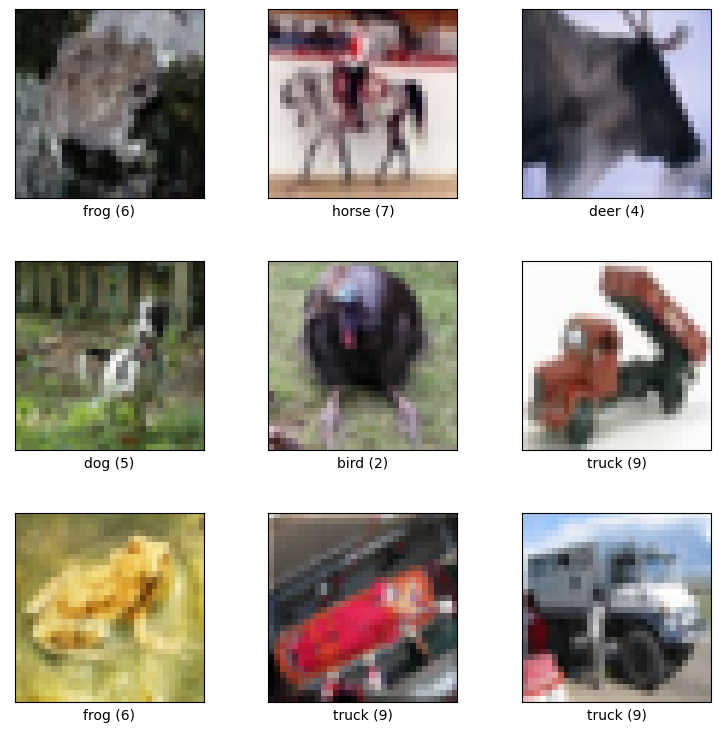

In [15]:
fig = tfds.show_examples(ds_train, ds_info)

# Buliding VGG

In [3]:
class vgg_block(layers.Layer):
    def __init__(self, n_filters, num_cnn=3, block_num=1):
        super(vgg_block, self).__init__()
        
        self.conv_blocks = []
        for i in range(1, num_cnn+1):
            self.conv = layers.Conv2D(n_filters, 3, activation='relu',
                                  kernel_initializer='he_normal',
                                  padding='same',
                                  name=f'block{block_num}_conv{i}')
            self.conv_blocks.append(self.conv)
            
        self.pool = layers.MaxPooling2D(pool_size=2, strides=2,
                                        name=f'block{block_num}_pooling')
        
    def call(self, x):
        for conv in self.conv_blocks:
            x = conv(x)
        x = self.pool(x)
        
        return x

In [26]:
class VGG(Model):
    def __init__(self, num_class=10,
                 num_cnn_list = [2,2,3,3,3],
                 channel_list = [64,128,256,512,512]):
        super(VGG, self).__init__()
        
        self.blocks = []
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            block = vgg_block(channel, num_cnn=num_cnn, block_num=i)
            self.blocks.append(block)
        
        self.flatten = layers.Flatten(name='flatten')
        self.fc1 = layers.Dense(4096, activation='relu', name='fc1')
        self.fc2 = layers.Dense(4096, activation='relu', name='fc2')
        self.fc3 = layers.Dense(num_class, activation='softmax', name='prediction')
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    def get_summary(self, input_shape=(32, 32, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [13]:
vgg_16 = VGG()
vgg_16.get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg_block (vgg_block)        (None, 16, 16, 64)        38720     
_________________________________________________________________
vgg_block_1 (vgg_block)      (None, 8, 8, 128)         221440    
_________________________________________________________________
vgg_block_2 (vgg_block)      (None, 4, 4, 256)         1475328   
_________________________________________________________________
vgg_block_3 (vgg_block)      (None, 2, 2, 512)         5899776   
_________________________________________________________________
vgg_block_4 (vgg_block)      (None, 1, 1, 512)         7079424   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0     

In [14]:
vgg_19 = VGG(num_cnn_list=[2,2,4,4,4],channel_list=[64,128,256,512,512])
vgg_19.get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
vgg_block_5 (vgg_block)      (None, 16, 16, 64)        38720     
_________________________________________________________________
vgg_block_6 (vgg_block)      (None, 8, 8, 128)         221440    
_________________________________________________________________
vgg_block_7 (vgg_block)      (None, 4, 4, 256)         2065408   
_________________________________________________________________
vgg_block_8 (vgg_block)      (None, 2, 2, 512)         8259584   
_________________________________________________________________
vgg_block_9 (vgg_block)      (None, 1, 1, 512)         9439232   
_________________________________________________________________
flatten (Flatten)            (None, 512)               0   

# Training VGG

In [15]:
BATCH_SIZE = 256
EPOCH = 70

In [16]:
(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.SGD(lr=.01, clipnorm=1.),
    metrics = ['accuracy']
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

c:\Users\User\miniconda3\envs\paper\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/70
195/195 [==============================] - 13s 30ms/step - loss: 2.1665 - accuracy: 0.1978 - val_loss: 2.0469 - val_accuracy: 0.2888
Epoch 2/70
195/195 [==============================] - 6s 31ms/step - loss: 1.9795 - accuracy: 0.2908 - val_loss: 1.9636 - val_accuracy: 0.2902
Epoch 3/70
195/195 [==============================] - 5s 28ms/step - loss: 1.8462 - accuracy: 0.3418 - val_loss: 1.7984 - val_accuracy: 0.3508
Epoch 4/70
195/195 [==============================] - 6s 28ms/step - loss: 1.7276 - accuracy: 0.3811 - val_loss: 1.7179 - val_accuracy: 0.3982
Epoch 5/70
195/195 [==============================] - 6s 28ms/step - loss: 1.6619 - accuracy: 0.4039 - val_loss: 1.6382 - val_accuracy: 0.4149
Epoch 6/70
195/195 [==============================] - 5s 28ms/step - loss: 1.5856 - accuracy: 0.4332 - val_loss: 1.5222 - val_accuracy: 0.4569
Epoch 7/70
195/195 [==============================] - 6s 28ms/step - loss: 1.5323 - accuracy: 0.4507 - val_loss: 1.4930 - val_accuracy: 0.465

In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/70
195/195 [==============================] - 8s 32ms/step - loss: 2.2202 - accuracy: 0.1713 - val_loss: 2.1340 - val_accuracy: 0.2408
Epoch 2/70
195/195 [==============================] - 6s 31ms/step - loss: 2.0487 - accuracy: 0.2507 - val_loss: 1.9797 - val_accuracy: 0.2808
Epoch 3/70
195/195 [==============================] - 6s 31ms/step - loss: 1.9143 - accuracy: 0.3074 - val_loss: 1.8465 - val_accuracy: 0.3347
Epoch 4/70
195/195 [==============================] - 6s 31ms/step - loss: 1.7929 - accuracy: 0.3541 - val_loss: 1.6944 - val_accuracy: 0.3835
Epoch 5/70
195/195 [==============================] - 6s 31ms/step - loss: 1.6926 - accuracy: 0.3890 - val_loss: 1.6850 - val_accuracy: 0.3886
Epoch 6/70
195/195 [==============================] - 6s 31ms/step - loss: 1.6247 - accuracy: 0.4139 - val_loss: 1.5492 - val_accuracy: 0.4470
Epoch 7/70
195/195 [==============================] - 6s 31ms/step - loss: 1.5708 - accuracy: 0.4325 - val_loss: 1.5700 - val_accuracy: 0.4386

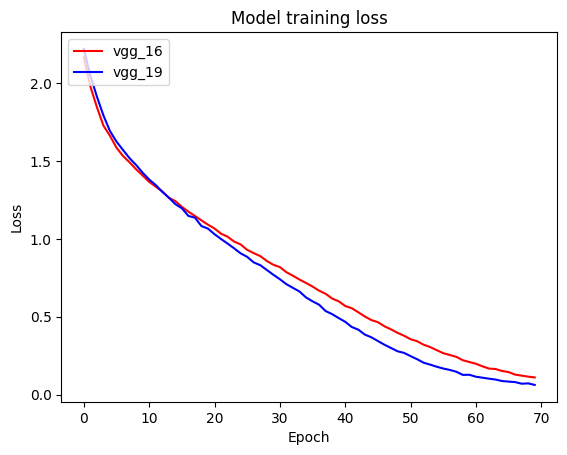

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

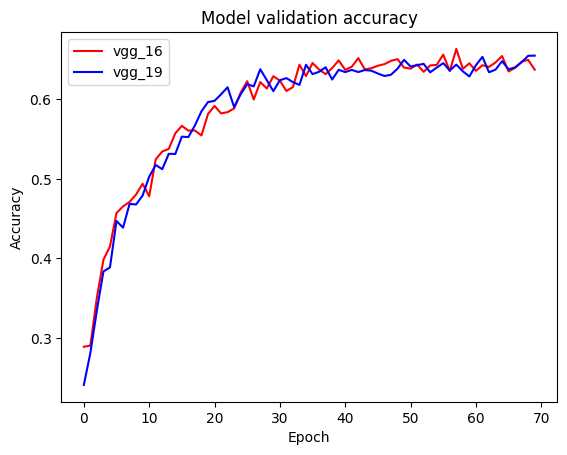

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

VGG 네트워크 test accuracy 비교 결과 (70 epochs)
|Dataset|VGG-19|VGG-16|
|--|--|--|
|cifar-10|0.6549|0.6372|

# Load Cats and dogs

In [4]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

In [5]:
print(ds_info.features)
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})
tf.Tensor(16283, shape=(), dtype=int64)
tf.Tensor(6979, shape=(), dtype=int64)


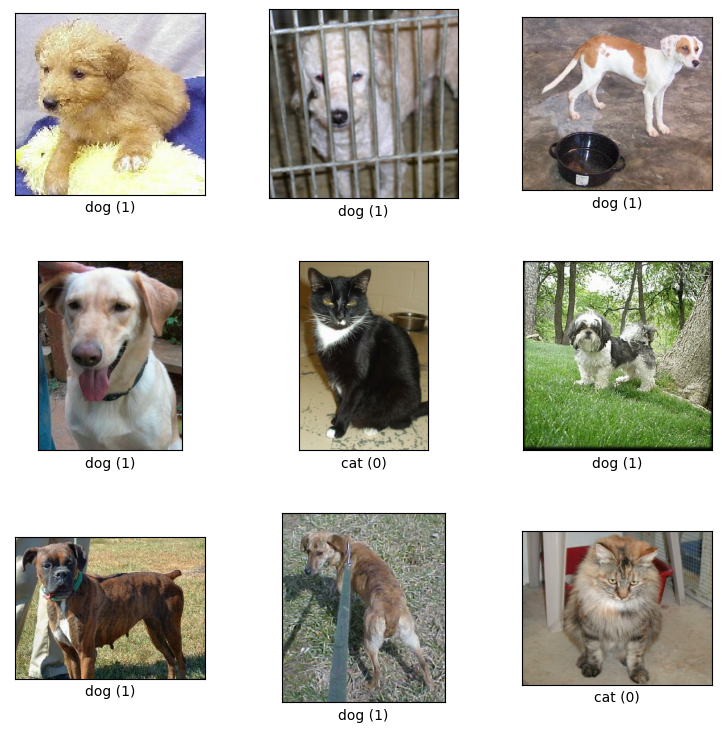

In [6]:
fig = tfds.show_examples(ds_train, ds_info)

이미지의 크기가 제각각이므로 resize도 필요

In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    image = tf.image.resize(image, [128, 128])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

이미지가 제각각이기 때문에 128x128로 통일해주었다.(224 or 200으로 했을 때 out of memory 발생)

In [14]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:70%]', 'train[70%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

train 데이터를 7:3 비율로 train, test로 나누어 주었다.

# VGG19

In [15]:
class VGG(Model):
    def __init__(self, num_class=10,
                 num_cnn_list = [2,2,3,3,3],
                 channel_list = [64,128,256,512,512]):
        super(VGG, self).__init__()
        
        self.blocks = []
        for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
            block = vgg_block(channel, num_cnn=num_cnn, block_num=i)
            self.blocks.append(block)
        
        self.flatten = layers.Flatten(name='flatten')
        self.fc1 = layers.Dense(4096, activation='relu', name='fc1')
        self.fc2 = layers.Dense(4096, activation='relu', name='fc2')
        self.fc3 = layers.Dense(num_class, activation='softmax', name='prediction')
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x
    def get_summary(self, input_shape=(128, 128, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [16]:
model3 = VGG(num_cnn_list=[2,2,4,4,4],channel_list=[64,128,256,512,512], num_class=2)
model3.get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg_block_5 (vgg_block)      (None, 64, 64, 64)        38720     
_________________________________________________________________
vgg_block_6 (vgg_block)      (None, 32, 32, 128)       221440    
_________________________________________________________________
vgg_block_7 (vgg_block)      (None, 16, 16, 256)       2065408   
_________________________________________________________________
vgg_block_8 (vgg_block)      (None, 8, 8, 512)         8259584   
_________________________________________________________________
vgg_block_9 (vgg_block)      (None, 4, 4, 512)         9439232   
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0   

In [17]:
BATCH_SIZE = 128
EPOCH = 30
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                               patience=10, 
#                              )

# reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=4,
# )

In [18]:
model3.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    metrics = ['accuracy'])

history_vgg = model3.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1
    # callbacks=[reduceLR, es]
)

Epoch 1/30
127/127 [==============================] - 33s 190ms/step - loss: 163.1621 - accuracy: 0.5059 - val_loss: 0.6926 - val_accuracy: 0.5346
Epoch 2/30
127/127 [==============================] - 23s 185ms/step - loss: 0.6922 - accuracy: 0.5165 - val_loss: 0.6931 - val_accuracy: 0.5022
Epoch 3/30
127/127 [==============================] - 23s 184ms/step - loss: 0.6958 - accuracy: 0.5234 - val_loss: 0.6892 - val_accuracy: 0.5332
Epoch 4/30
127/127 [==============================] - 22s 177ms/step - loss: 0.6899 - accuracy: 0.5237 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 5/30
127/127 [==============================] - 23s 178ms/step - loss: 0.6964 - accuracy: 0.5018 - val_loss: 0.6937 - val_accuracy: 0.5014
Epoch 6/30
127/127 [==============================] - 22s 177ms/step - loss: 0.6933 - accuracy: 0.5113 - val_loss: 0.6941 - val_accuracy: 0.4955
Epoch 7/30
127/127 [==============================] - 22s 177ms/step - loss: 0.6932 - accuracy: 0.5041 - val_loss: 0.6895 - val_

# Building ResNet
함수형으로 짜기

## ResNet-50

In [19]:
# block 안에 반복적으로 활용되는 L2 regularizer를 선언해 줍니다.
def _gen_l2_regularizer(use_l2_regularizer=True, l2_weight_decay=1e-4):
  return regularizers.l2(l2_weight_decay) if use_l2_regularizer else None

In [20]:
def conv_block(inputs, kernel_size, filters, stage, block, strides=2,
               use_l2_regularizer=True, batch_norm_decay=0.9, batch_norm_epsilon=1e-5):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = layers.Conv2D(filters[0], 1, use_bias=False, name=conv_name_base + '2a',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(inputs)
    x = layers.BatchNormalization(name=bn_name_base + '2a',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[1], kernel_size, strides=strides, padding='same', use_bias=False, name = conv_name_base + '2b',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[2], 1, use_bias=False, name=conv_name_base + '2c',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    shortcut = layers.Conv2D(filters[2], 1,strides=strides, use_bias=False, name=conv_name_base + '1',
                             kernel_initializer='he_normal', kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(inputs)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)
    
    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    
    return x  

In [21]:
def identity_block(inputs, kernel_size, filters, stage, block, use_l2_regularizer=True,
                   batch_norm_decay=0.9, batch_norm_epsilon=1e-5):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = layers.Conv2D(filters[0], 1, use_bias=False, name=conv_name_base + '2a',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(inputs)
    x = layers.BatchNormalization(name=bn_name_base + '2a',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[1], kernel_size, padding='same', use_bias=False, name = conv_name_base + '2b',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[2], 1, use_bias=False, name=conv_name_base + '2c',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.add([x, inputs])
    x = layers.Activation('relu')(x)
    return x

In [22]:
def resnet50(input_shape, num_classes, use_l2_regularizer=True,
             batch_norm_decay=0.9, batch_norm_epsilon=1e-5,):
    block_config = dict(
        use_l2_regularizer = use_l2_regularizer,
        batch_norm_decay = batch_norm_decay,
        batch_norm_epsilon = batch_norm_epsilon
    )
    
    inputs = layers.Input(shape=input_shape, name='input')
    
    x = layers.ZeroPadding2D(3, name='conv1_pad')(inputs)
    x = layers.Conv2D(64, 7, strides=2, padding='valid', use_bias=False, name='conv1',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name='bn_conv1',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = conv_block(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='a', strides=1, **block_config)
    x = identity_block(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='b', **block_config)
    x = identity_block(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='c', **block_config)
    
    x = conv_block(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='a', **block_config)
    x = identity_block(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='b', **block_config)
    x = identity_block(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='c', **block_config)
    x = identity_block(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='d', **block_config)
    
    x = conv_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='a', **block_config)
    x = identity_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='b', **block_config)
    x = identity_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='c', **block_config)
    x = identity_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='d', **block_config)
    x = identity_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='e', **block_config)
    x = identity_block(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='f', **block_config)
    
    x = conv_block(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='a', **block_config)
    x = identity_block(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='b', **block_config)
    x = identity_block(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='c', **block_config)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     name='fc1000')(x)
      
    x = layers.Activation('softmax', dtype='float32')(x)
    
    return Model(inputs, x, name='resnet50')

In [23]:
model = resnet50(input_shape=(128,128,3),num_classes=2)

model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 134, 134, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 64, 64, 64)   9408        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 64, 64, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

##  Training ResNet

In [25]:
BATCH_SIZE = 128
EPOCH = 30
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                               patience=10, 
#                              )

# reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=4,
# )

In [24]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    metrics = ['accuracy'])

history_res = model.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks=[reduceLR, es]
)

Epoch 1/30
127/127 [==============================] - 24s 136ms/step - loss: 4.8994 - accuracy: 0.6510 - val_loss: 3.9541 - val_accuracy: 0.5586
Epoch 2/30
127/127 [==============================] - 17s 133ms/step - loss: 2.6251 - accuracy: 0.7278 - val_loss: 1.9972 - val_accuracy: 0.7345
Epoch 3/30
127/127 [==============================] - 16s 129ms/step - loss: 1.6168 - accuracy: 0.7877 - val_loss: 1.7383 - val_accuracy: 0.6862
Epoch 4/30
127/127 [==============================] - 17s 131ms/step - loss: 1.1979 - accuracy: 0.8263 - val_loss: 5.2065 - val_accuracy: 0.5194
Epoch 5/30
127/127 [==============================] - 16s 129ms/step - loss: 1.0074 - accuracy: 0.8483 - val_loss: 4.6489 - val_accuracy: 0.7665
Epoch 6/30
127/127 [==============================] - 16s 129ms/step - loss: 0.8715 - accuracy: 0.8711 - val_loss: 1.1032 - val_accuracy: 0.7279
Epoch 7/30
127/127 [==============================] - 16s 130ms/step - loss: 0.7550 - accuracy: 0.8932 - val_loss: 0.8622 - val_ac

# Plain-50

## build

ResNet50 과 똑같은 블록 구조에 shortcut만 삭제해 주었다.

In [26]:
def conv_block_plain(inputs, kernel_size, filters, stage, block, strides=2,
               use_l2_regularizer=True, batch_norm_decay=0.9, batch_norm_epsilon=1e-5):
    
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = layers.Conv2D(filters[0], 1, use_bias=False, name=conv_name_base + '2a',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(inputs)
    x = layers.BatchNormalization(name=bn_name_base + '2a',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[1], kernel_size, strides=strides, padding='same', use_bias=False, name = conv_name_base + '2b',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[2], 1, use_bias=False, name=conv_name_base + '2c',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    return x  

In [27]:
def identity_block_plain(inputs, kernel_size, filters, stage, block, use_l2_regularizer=True,
                   batch_norm_decay=0.9, batch_norm_epsilon=1e-5):
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    x = layers.Conv2D(filters[0], 1, use_bias=False, name=conv_name_base + '2a',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(inputs)
    x = layers.BatchNormalization(name=bn_name_base + '2a',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[1], kernel_size, padding='same', use_bias=False, name = conv_name_base + '2b',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2b',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    
    x = layers.Conv2D(filters[2], 1, use_bias=False, name=conv_name_base + '2c',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name=bn_name_base + '2c',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)

    return x

In [28]:
def plain50(input_shape, num_classes, use_l2_regularizer=True,
             batch_norm_decay=0.9, batch_norm_epsilon=1e-5,):
    block_config = dict(
        use_l2_regularizer = use_l2_regularizer,
        batch_norm_decay = batch_norm_decay,
        batch_norm_epsilon = batch_norm_epsilon
    )
    
    inputs = layers.Input(shape=input_shape, name='input')
    
    x = layers.ZeroPadding2D(3, name='conv1_pad')(inputs)
    x = layers.Conv2D(64, 7, strides=2, padding='valid', use_bias=False, name='conv1',
                      kernel_initializer='he_normal',
                      kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer))(x)
    x = layers.BatchNormalization(name='bn_conv1',
                                  momentum=batch_norm_decay,
                                  epsilon=batch_norm_epsilon)(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    
    x = conv_block_plain(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='a', strides=1, **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='b', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[64, 64, 256], stage=2, block='c', **block_config)
    
    x = conv_block_plain(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='a', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='b', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='c', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[128, 128, 512], stage=3, block='d', **block_config)
    
    x = conv_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='a', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='b', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='c', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='d', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='e', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[256, 256, 1024], stage=4, block='f', **block_config)
    
    x = conv_block_plain(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='a', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='b', **block_config)
    x = identity_block_plain(x, kernel_size=3, filters=[512, 512, 2048], stage=5, block='c', **block_config)
    
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes,
                     kernel_initializer=initializers.RandomNormal(stddev=0.01),
                     kernel_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     bias_regularizer=_gen_l2_regularizer(use_l2_regularizer),
                     name='fc1000')(x)
      
    x = layers.Activation('softmax', dtype='float32')(x)
    
    return Model(inputs, x, name='plain50')

In [29]:
model2 = plain50(input_shape=(128,128,3),num_classes=2)

model2.summary()

Model: "plain50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 134, 134, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 64)        9408      
_________________________________________________________________
bn_conv1 (BatchNormalization (None, 64, 64, 64)        256       
_________________________________________________________________
activation_66 (Activation)   (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
res2a_branch2a (Conv2D)      (None, 32, 32, 64)        4096

## Train

In [20]:
BATCH_SIZE = 128
EPOCH = 30
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
#                               patience=10, 
#                              )

# reduceLR = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_accuracy',
#     factor=0.5,
#     patience=4,
# )

In [30]:
model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(beta_1=0.9, beta_2=0.98, epsilon=1e-9),
    metrics = ['accuracy'])

history_plain = model2.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:70%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[70%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    # callbacks=[reduceLR, es]
)

Epoch 1/30
127/127 [==============================] - 19s 108ms/step - loss: 4.2323 - accuracy: 0.5107 - val_loss: 3.1865 - val_accuracy: 0.4991
Epoch 2/30
127/127 [==============================] - 13s 104ms/step - loss: 2.5835 - accuracy: 0.5789 - val_loss: 2.1094 - val_accuracy: 0.6133
Epoch 3/30
127/127 [==============================] - 13s 106ms/step - loss: 1.8238 - accuracy: 0.5955 - val_loss: 1.6010 - val_accuracy: 0.5716
Epoch 4/30
127/127 [==============================] - 13s 105ms/step - loss: 1.4593 - accuracy: 0.5589 - val_loss: 1.3954 - val_accuracy: 0.4952
Epoch 5/30
127/127 [==============================] - 13s 106ms/step - loss: 1.2660 - accuracy: 0.5704 - val_loss: 1.1900 - val_accuracy: 0.4941
Epoch 6/30
127/127 [==============================] - 13s 105ms/step - loss: 1.0703 - accuracy: 0.5718 - val_loss: 1.0083 - val_accuracy: 0.4973
Epoch 7/30
127/127 [==============================] - 13s 104ms/step - loss: 0.9177 - accuracy: 0.5854 - val_loss: 0.8876 - val_ac

# Visualization

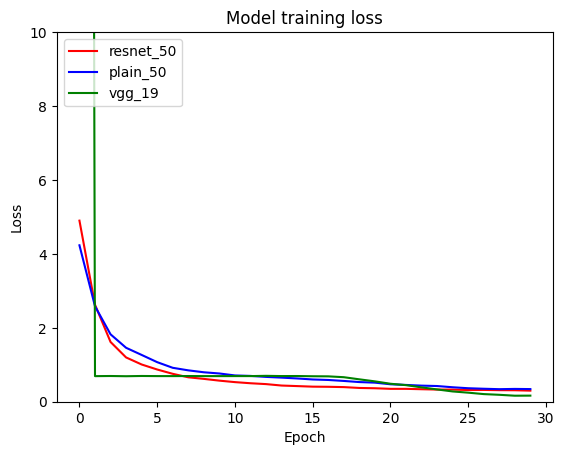

In [33]:
import matplotlib.pyplot as plt

plt.plot(history_res.history['loss'], 'r')
plt.plot(history_plain.history['loss'], 'b')
plt.plot(history_vgg.history['loss'], 'g')
plt.title('Model training loss')
plt.ylim(0,10)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet_50','plain_50','vgg_19'], loc='upper left')
plt.show()

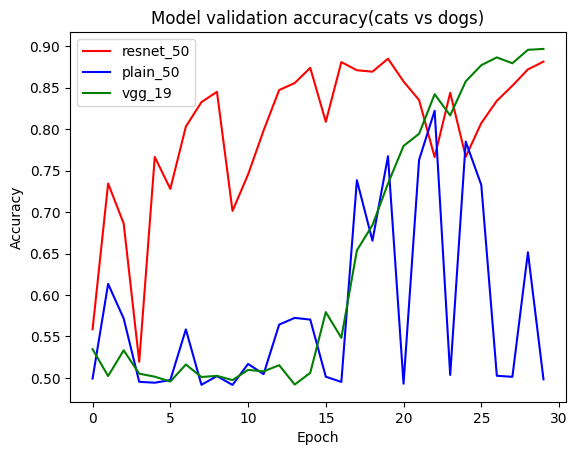

In [34]:
plt.plot(history_res.history['val_accuracy'], 'r')
plt.plot(history_plain.history['val_accuracy'], 'b')
plt.plot(history_vgg.history['val_accuracy'], 'g')
plt.title('Model validation accuracy(cats vs dogs)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet_50','plain_50','vgg_19'], loc='upper left')
plt.show()

# 결과 표

resnet50과 plain 50 네트워크 test accuracy 비교 결과 (30 epochs)
|Dataset|ResNet-50|Plain-50|VGG-19|
|--|--|--|--|
|cats vs dogs|0.8815|0.4982|0.8968|


Plain 네트워크 만으로는 학습이 잘 되지 않았다.  
vgg19의 성능이 0.8968로 가장 좋았고 ResNet의 파라미터수가 약 1/4 임에도 같은 epoch에서 비슷한 성능을 보였다.